# TensorFlow Lite conversion examples
These are conversion examples according to
[Introduction to TensorFlow Lite](https://www.udacity.com/course/intro-to-tensorflow-lite--ud190)
video course.

## Example 1. Convert saved model into TF Lite model
Convert TensorFlow saved model to TensorFlow Lite model.

Save the equation `y=2x-1` model and convert it to TF Lite.

### Get TF Lite file

In [41]:
# As I can see video course is for TF version 2.0 (stable)
!pip -q install tensorflow-gpu==2.0

import tensorflow as tf
print(tf.__version__)

2.0.0


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import pathlib
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

In [43]:
# Store data for x and y
x = [-1, 0, 1, 2, 3, 4]
y = [-3, -1, 1, 3, 5, 7]

# Create a simple Keras model with 1 dense layer and 1 neuron
# Train for 500 epochs using stocastic gradient descent (sgd) as an optimizer
# and setting loss function to be the mean squared error.
model = tf.keras.models.Sequential([tf.keras.layers.Dense(units=1, input_shape=[1])])
model.compile(optimizer='sgd', loss='mean_squared_error')
model.fit(x, y, epochs=500, verbose=0)

In [44]:
import os
import pathlib

# Export the SavedModel
home_dir = '/content/sample_data'
export_dir = os.path.join(home_dir, 'tmp')
filename = os.path.join(home_dir, 'foo1.tflite')

tf.saved_model.save(model, export_dir)

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
# Option target_ops is for TF version < 2.0
# converter.target_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = converter.convert()

# Save the model
tf_lite_model_file = pathlib.Path(filename)
tf_lite_model_file.write_bytes(tflite_model)

INFO:tensorflow:Assets written to: /content/sample_data/tmp/assets


792

In [45]:
# Check it
!ls -hal "{filename}"

-rw-r--r-- 1 root root 792 Oct 22 12:09 /content/sample_data/foo1.tflite


### Initialize the TFLite interpreter to try it out

In [0]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [0]:
# Test the TF Lite model on random input data
input_shape = input_details[0]['shape']
inputs, outputs1, outputs2 = [], [], []
for _ in range(100):
    input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)

    interpreter.invoke()
    tflite_results = interpreter.get_tensor(output_details[0]['index'])
    output_data = np.array(tflite_results)

    inputs.append(input_data[0][0])
    outputs1.append(output_data[0][0])

    # Test the TF model on random input data
    tf_results = model(tf.constant(input_data))
    output_data = np.array(tf_results)

    outputs2.append(output_data[0][0])

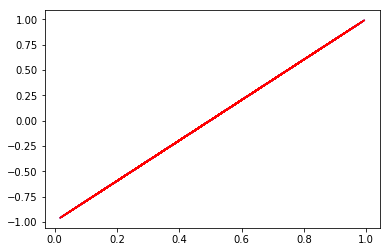

In [55]:
# Visualize the model
plt.plot(inputs, outputs2, 'b')
plt.plot(inputs, outputs1, 'r')
plt.show()

In [0]:
# Download the TFLite model file
try:
    from google.colab import files
    files.download(filename)
except Exception as err:
    print(err)

## Example 2. Convert TF Keras model into TF Lite model

In [16]:
import tensorflow as tf
import pathlib

# Load the MobileNet tf.keras pre-trained model
model = tf.keras.applications.MobileNetV2(weights='imagenet', input_shape=(224, 224, 3))

# Save model into HDF5 file
model.save(os.path.join(home_dir, 'model.h5'))

# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model
home_dir = '/content/sample_data'
filename = os.path.join(home_dir, 'foo2.tflite')
tflite_model_file = pathlib.Path(filename)
tflite_model_file.write_bytes(tflite_model)

13978384

In [6]:
# Check it
!ls -hal "{filename}"

-rw-r--r-- 1 root root 14M Oct 22 09:16 /content/sample_data/foo2.tflite


## Example 3. Convert concrete function into TF Lite model

In [7]:
import tensorflow as tf

# Load the MobileNet tf.keras pre-trained model
model = tf.keras.applications.MobileNetV2(weights='imagenet', input_shape=(224, 224, 3))

# Get the concrete function from the Keras model
# Create callable TF graph of the model by passing a model's forward path to the tf.function.
run_model = tf.function(lambda x: model(x))

# Save the concrete function
concrete_func = run_model.get_concrete_function(tf.TensorSpec(model.inputs[0].shape,
                                                              model.inputs[0].dtype))

# Save the model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
tflite_model = converter.convert()

# Save the model
home_dir = '/content/sample_data'
filename = os.path.join(home_dir, 'foo3.tflite')
tflite_model_file = pathlib.Path(filename)
tflite_model_file.write_bytes(tflite_model)

13978380

In [8]:
# Check it
!ls -hal "{filename}"

-rw-r--r-- 1 root root 14M Oct 22 09:40 /content/sample_data/foo3.tflite


## Example 4. Command-line usage

In [10]:
#!/usr/bin/env bash

home_dir = '/content/sample_data'
export_dir = os.path.join(home_dir, 'tmp')
filename = os.path.join(home_dir, 'foo4.tflite')

# Saving with the command-line from a SavedModel
!tflite_convert --output_file="{filename}" \
                --saved_model_dir="{export_dir}"

2019-10-22 09:44:39.958145: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2019-10-22 09:44:39.961201: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1006] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-10-22 09:44:39.961918: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla K80 major: 3 minor: 7 memoryClockRate(GHz): 0.8235
pciBusID: 0000:00:04.0
2019-10-22 09:44:39.962194: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2019-10-22 09:44:39.963605: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2019-10-22 09:44:39.965282: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10

In [11]:
# Check it
!ls -hal "{filename}"

-rw-r--r-- 1 root root 780 Oct 22 09:44 /content/sample_data/foo4.tflite


In [17]:
#!/usr/bin/env bash

home_dir = '/content/sample_data'
filename = os.path.join(home_dir, 'foo5.tflite')
model_file = os.path.join(home_dir, 'model.h5')

# Saving with the command-line from a Keras model
!tflite_convert --output_file="{filename}" \
                --keras_model_file="{model_file}"

2019-10-22 09:56:15.099704: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2019-10-22 09:56:15.102794: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1006] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-10-22 09:56:15.103518: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla K80 major: 3 minor: 7 memoryClockRate(GHz): 0.8235
pciBusID: 0000:00:04.0
2019-10-22 09:56:15.103752: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2019-10-22 09:56:15.106159: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2019-10-22 09:56:15.108187: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10

In [18]:
# Check it
!ls -hal "{filename}"

-rw-r--r-- 1 root root 14M Oct 22 09:56 /content/sample_data/foo5.tflite


## Post-training quantizations

In [32]:
import os
import pathlib

# Export the SavedModel
home_dir = '/content/sample_data'
export_dir = os.path.join(home_dir, 'tmp')
filename = os.path.join(home_dir, 'foo_quant1.tflite')

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

# Post-training quantization
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]

tflite_quant_model_1 = converter.convert()

# Save the model
tf_lite_model_file = pathlib.Path(filename)
tf_lite_model_file.write_bytes(tflite_quant_model_1)

3584424

In [33]:
# Check it
!ls -hal "{filename}"

-rw-r--r-- 1 root root 3.5M Oct 22 11:46 /content/sample_data/foo_quant1.tflite


## Post-training integer quantization
Quantize both the weights and the activation outputs of the model by using the DEFAULT option.

In other to quantize the activations TF Lite needs to **gather calibration data** by running inferences on a small set of inputs. So as to determine the right scaling parameters needed to convert model to an integer quantized model.

In other words TF Lite needs to **measure the dynamic range** of the activations and inputs with a representative dataset in other to quaqntize the activations.

Post-Training Decision Tree:

![TF Lite optimizations](https://raw.githubusercontent.com/foobar167/articles/master/Machine_Learning/data/2019.10.22_tf-lite_optimization.jpg)

In [0]:
!pip install tensorflow-datasets

import os
import pathlib
import tensorflow as tf
import tensorflow_datasets as tfds


# Export the SavedModel
home_dir = '/content/sample_data'
export_dir = os.path.join(home_dir, 'tmp')
filename = os.path.join(home_dir, 'foo_quant2.tflite')
model_file = os.path.join(home_dir, 'model.h5')

# NOT FINISHED! You must set tfds.load(...) function.

# Define the generator to generate samples from our dataset
def generator():
    data = tfds.load(...)
    for _ in range(num_calibration_stps):
        image, = data.take(1)
        yield [image]


# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

# Set the optimization mode to DEFAULT
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Pass the representative dataset to the converter
converter.representative_dataset = tf.lite.RepresentativeDataset(generator)

# Restricting supported target ops specification to INT8
# In other words, make it all INT8 without floating point, so the model can be
# executed ENTIRELY on integer only hardware accelerators such as Edge TPU.
# However, if the converter comes across the operation, that cannot be
# quantized an error may be raised.
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

tflite_quant_model_2 = converter.convert()

# Save the model
tf_lite_model_file = pathlib.Path(filename)
tf_lite_model_file.write_bytes(tflite_quant_model_2)

In [0]:
# Check it
!ls -hal "{filename}"

## TF Lite interpreter in Python

In [0]:
# Load TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_content=tflite_quant_model_1)
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# NOT FINISHED! You must set 'input_data' parameter.

# Point the data to be used for testing and run the interpreter
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])